In [26]:
from IPython.core.display import HTML, display

import pymc3 as pm
import theano.tensor as tt
from theano import shared

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from seaborn import heatmap
import matplotlib.pyplot as pl
from matplotlib import rcParams
from cmocean import cm as cmo

from pymc_utils import PyMCModel

In [2]:
display(HTML("<style>.container {width: 90% !important}</style>"))

In [3]:
% matplotlib inline
rcParams['axes.titlesize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16

In [41]:
def bayes_nn_model_l1(X, y_obs, n_hidden, lklhd_name='likelihood'):
    
    """
    Hierarchical Bayesian NN Implementation.
    
    Inputs:
    --------
    X: theano shared variable,
    y_obs: numpy vector,
    n_hidden: number of hidden layer neurons,
    lklhd_name: name of the likelihood variable.
    
    Output:
    --------
    PyMC3 model
    """
    
    X = pm.floatX(X)
    Y = pm.floatX(y_obs)
    if hasattr(X, 'name'):
        num_obs, num_feats = X.eval().shape
    else:
        num_obs, num_feats = X.shape
    with pm.Model() as model:
        init_b1 = np.random.randn(n_hidden,)
        init_w1 = np.random.randn(num_feats, n_hidden)
        init_w2 = np.random.randn(n_hidden,)
        w1 = pm.Normal('wts_layer1', mu=0, sd=1, shape=(num_feats, n_hidden), 
                      testval=init_w1)
        w2 = pm.Normal('wts_layer2', mu=0, sd=1, shape=(n_hidden,),
                      testval=init_w2)
        
        b1 = pm.Normal('bias_layer1', mu=0, sd=1, shape=(n_hidden,), testval=init_b1)
        b2 = pm.Normal('bias_layer2', mu=0, sd=1, shape=(1,))
        
        lyr1_act = pm.Deterministic('layer1_act', tt.nnet.relu(tt.dot(X, w1)) + b1)
        out_act = pm.Deterministic('out_act', tt.dot(lyr1_act, w2) + b2)
        
        sd = pm.HalfCauchy('sd', beta=2.5)
        output = pm.Normal(lklhd_name, mu=out_act, sd=sd, observed=Y)
    return model

In [53]:
def bayes_nn_model_l1_no_bias(X, y_obs, n_hidden, lklhd_name='likelihood'):
    
    """
    Hierarchical Bayesian NN Implementation.
    
    Inputs:
    --------
    X: theano shared variable,
    y_obs: numpy vector,
    n_hidden: number of hidden layer neurons,
    lklhd_name: name of the likelihood variable.
    
    Output:
    --------
    PyMC3 model
    """
    
    X = pm.floatX(X)
    Y = pm.floatX(y_obs)
    if hasattr(X, 'name'):
        num_obs, num_feats = X.eval().shape
    else:
        num_obs, num_feats = X.shape
    with pm.Model() as model:
        #init_b1 = np.random.randn(n_hidden,)
        init_w1 = np.random.randn(num_feats, n_hidden)
        init_w2 = np.random.randn(n_hidden,)
        wi_1 = pm.Normal('wts_i_1', mu=0, sd=1, shape=(num_feats, n_hidden), 
                      testval=init_w1)
        w1_2 = pm.Normal('wts_1_2', mu=0, sd=1, shape=(n_hidden,),
                      testval=init_w2)
        
        #b1 = pm.Normal('bias_layer1', mu=0, sd=1, shape=(n_hidden,), testval=init_b1)
        #b2 = pm.Normal('bias_layer2', mu=0, sd=1, shape=(1,))
        
        lyr1_act = pm.Deterministic('layer1_act', tt.nnet.relu(tt.dot(X, w1)) )#+ b1)
        out_act = pm.Deterministic('out_act', tt.dot(lyr1_act, w2) )#+ b2)
        
        sd = pm.HalfCauchy('sd', beta=2.5)
        output = pm.Normal(lklhd_name, mu=out_act, sd=sd, observed=Y)
    return model

In [5]:
def bayes_nn_model_l1_h(X, y_obs, n_hidden, lklhd_name='likelihood'):
    """
    Hierarchical Bayesian NN Implementation.
    
    Inputs:
    --------
    X: theano shared variable,
    y_obs: numpy vector,
    n_hidden: number of hidden layer neurons,
    lklhd_name: name of the likelihood variable.
    
    Output:
    --------
    PyMC3 model
    """
    
    X = pm.floatX(X)
    Y = pm.floatX(y_obs)
    if hasattr(X, 'name'):
        num_obs, num_feats = X.eval().shape
    else:
        num_obs, num_feats = X.shape
    with pm.Model() as model:
        init_1 = np.random.randn(num_feats, n_hidden)
        init_2 = np.random.randn(n_hidden,)
        hyper_w1_sd = pm.HalfCauchy('hyper_w1_sd', beta=1)
        hyper_w2_sd = pm.HalfCauchy('hyper_w2_sd', beta=1)
        w1 = pm.Normal('wts_layer1', mu=0, sd=hyper_w1_sd, shape=(num_feats, n_hidden), 
                      testval=init_1)
        w2 = pm.Normal('wts_layer2', mu=0, sd=hyper_w2_sd, shape=(n_hidden,),
                      testval=init_2)
        
        b1 = pm.Normal('bias_layer1', mu=0, sd=1, shape=(n_hidden,))
        b2 = pm.Normal('bias_layer2', mu=0, sd=1, shape=(1,))
        
        lyr1_act = pm.Deterministic('layer1_act', tt.nnet.relu(tt.dot(X, w1)) + b1)
        out_act = pm.Deterministic('out_act', tt.dot(lyr1_act, w2) + b2)
        
        sd = pm.HalfCauchy('sd', beta=2.5)
        output = pm.Normal(lklhd_name, mu=out_act, sd=sd, observed=Y)
    return model

In [247]:
def bayes_nn_model2_l2_h(X, y_obs, n_hidden1, n_hidden2, lklhd_name='likelihood', include_bias=False):
    """
    Hierarchical Bayesian NN Implementation.
    
    Inputs:
    --------
    X: theano shared variable,
    y_obs: numpy vector,
    n_hidden: number of hidden layer neurons,
    lklhd_name: name of the likelihood variable.
    
    Output:
    --------
    PyMC3 model
    """
    X = pm.floatX(X)
    Y = pm.floatX(y_obs)
    if hasattr(X, 'name'):
        num_obs, num_feats = X.eval().shape
    else:
        num_obs, num_feats = X.shape
    with pm.Model() as model:
        init_1 = np.random.randn(num_feats, n_hidden1)
        init_2 = np.random.randn(n_hidden1, n_hidden2)
        init_3 = np.random.randn(n_hidden2,)
        if include_bias:   
            init_b1 = np.random.randn(n_hidden1,)
            init_b2 = np.random.randn(n_hidden2,)
            init_b3 = np.random.randn()
            b1 = pm.Normal('bias_layer1', mu=0, sd=1, shape=(n_hidden1,),
                           testval=init_b1)
            b2 = pm.Normal('bias_layer2', mu=0, sd=1, shape=(n_hidden2,),
                          testval=init_b2)
            b3 = pm.Normal('bias_layer3', mu=0, sd=1, testval=init_b3)
        else:
            b1, b2, b3 = 0, 0, 0
        hyper_w1_sd = pm.HalfCauchy('hyper_w1_sd', beta=1)
        hyper_w2_sd = pm.HalfCauchy('hyper_w2_sd', beta=1)
        hyper_w3_sd = pm.HalfCauchy('hyper_w3_sd', beta=1)
        w1 = pm.Normal('wts_i_1', mu=0, sd=hyper_w1_sd, shape=(num_feats, n_hidden1), 
                      testval=init_1)
        w2 = pm.Normal('wts_1_2', mu=0, sd=hyper_w2_sd, shape=(n_hidden1, n_hidden2),
                      testval=init_2)
        w3 = pm.Normal('wts_2_out', mu=0, sd=hyper_w3_sd, shape=(n_hidden2,),
                      testval=init_3)
        lyr1_act = pm.Deterministic('layer1_act', tt.nnet.relu(tt.dot(X, w1)) + b1)
        lyr2_act = pm.Deterministic('layer2_act', tt.nnet.relu(tt.dot(lyr1_act, w2)) + b2)
        out_act = pm.Deterministic('layer3_act', tt.dot(lyr2_act, w3) + b3)
        
        sd = pm.HalfCauchy('sd', beta=2.5)
        output = pm.Normal(lklhd_name, mu=out_act, sd=sd, observed=Y)
    return model

In [7]:
ds = pd.read_pickle('./pickleJar/OperationalDataSets/df_rs_6_FullSet_noInteractions.pkl')

In [66]:
feat_beg = 'sin_doy'
feat_end_ni = 'PC6_s'
X_s = ds.dropna().loc[:, feat_beg: feat_end_ni]
X_s_pc_only = ds.dropna().filter(regex='PC_', axis=1)
lbls_X_s = X_s.columns.tolist()
y = ds.dropna().log10_chl
y_s = (y - y.mean()) / y.std()

In [9]:
X_s_train, X_s_test, y_train, y_test = train_test_split(X_s, y, test_size=0.1,
                                                       random_state=42)

In [40]:
ds.dropna().loc[:, feat_beg: feat_end_ni].describe().T

,count,mean,std,min,25%,50%,75%,max
sin_doy,423.0,0.034586,0.736574,-0.999991,-0.785650,0.068802,0.772149,0.999917
cos_doy,423.0,-0.088471,0.671404,-0.999963,-0.755493,-0.115935,0.512371,0.999852
sin_minofday,423.0,-0.746963,0.405304,-1.000000,-0.983255,-0.880891,-0.751840,1.000000
cos_minofday,423.0,-0.147062,0.507094,-0.999962,-0.533615,-0.143493,0.207912,0.992005
x,423.0,0.142699,0.343028,-0.989566,0.096998,0.129139,0.275427,0.992996
y,423.0,-0.670779,0.340431,-0.895108,-0.881073,-0.769503,-0.669126,0.914999
z,423.0,0.439241,0.322483,-0.924832,0.447379,0.502754,0.599578,0.981627
log10_etopo2_s,423.0,-0.136844,0.878291,-5.813788,-0.665494,-0.073244,0.396601,1.099531
oisst_s,423.0,0.044374,0.605687,-1.657041,-0.399822,0.135051,0.528210,0.969347
solz_s,423.0,-0.085063,0.671178,-1.471526,-0.605923,-0.036446,0.444191,1.712984


In [24]:
Xy_train = pd.concat((X_s_train, y_train), axis=1)

In [37]:
X_s_train.describe().T

,count,mean,std,min,25%,50%,75%,max
sin_doy,380.0,0.040592,0.735587,-0.999991,-0.772135,0.085962,0.778899,0.999917
cos_doy,380.0,-0.084831,0.672817,-0.999963,-0.746951,-0.115935,0.516048,0.999852
sin_minofday,380.0,-0.748327,0.401730,-1.000000,-0.983255,-0.883951,-0.751840,1.000000
cos_minofday,380.0,-0.154165,0.505916,-0.999962,-0.534536,-0.152123,0.195090,0.992005
x,380.0,0.140379,0.347055,-0.989566,0.098496,0.138194,0.275474,0.992996
y,380.0,-0.668440,0.340676,-0.895108,-0.881071,-0.765693,-0.668495,0.901759
z,380.0,0.439724,0.323288,-0.924832,0.444262,0.502785,0.600420,0.981627
log10_etopo2_s,380.0,-0.130326,0.895757,-5.813788,-0.648832,-0.056186,0.403844,1.099531
oisst_s,380.0,0.029150,0.610366,-1.657041,-0.419147,0.117281,0.527988,0.969347
solz_s,380.0,-0.082808,0.670034,-1.471526,-0.596811,-0.034169,0.435080,1.712984


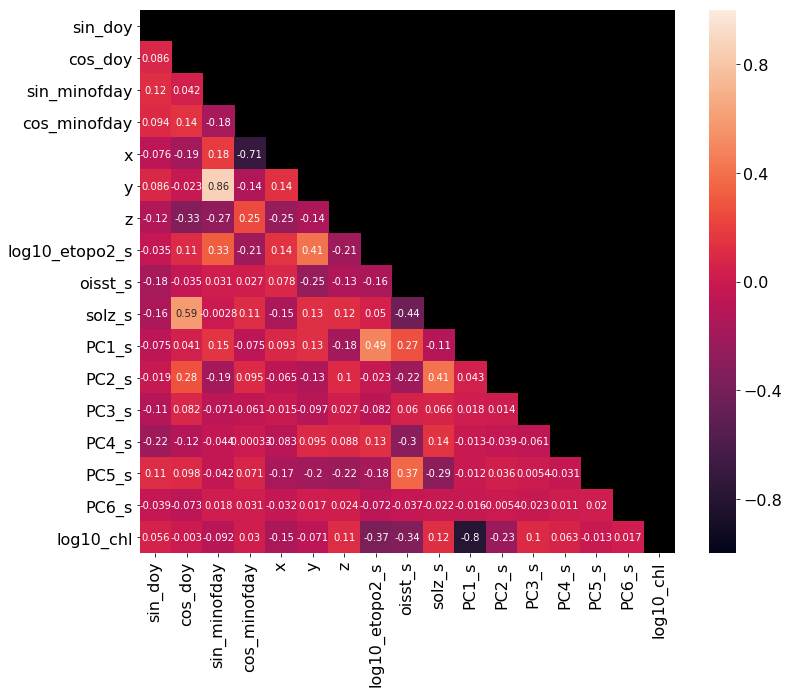

In [33]:
f, ax = pl.subplots(figsize=(12, 10))
heatmap(Xy_train.corr(),vmin=-1, vmax=1, mask=np.triu(np.ones([Xy_train.shape[1]] * 2)), ax=ax,
        annot=True, annot_kws={'fontsize': 10})
ax.set_facecolor('k')

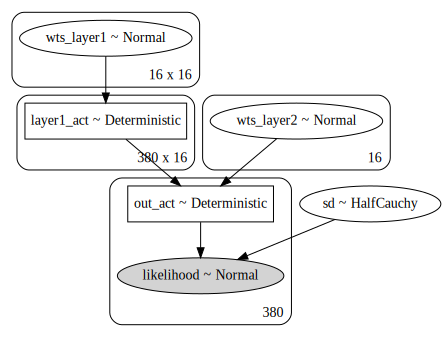

In [105]:
X_shared = shared(X_s_train.values)
bnn_l1_nb = PyMCModel(bayes_nn_model_l1_no_bias, X_shared, y_train, n_hidden=16)
bnn_l1_nb.show_model()

In [106]:
bnn_l1_nb.fit_ADVI()

Average Loss = 140.24: 100%|██████████| 100000/100000 [00:56<00:00, 1779.31it/s]
Finished [100%]: Average Loss = 140.29


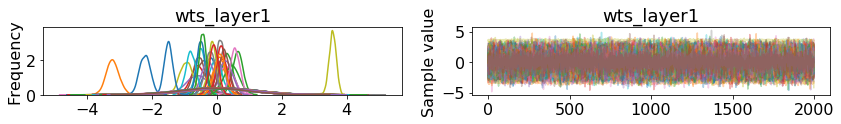

In [107]:
bnn_l1_nb.evaluate_fit(['wts_layer1']);

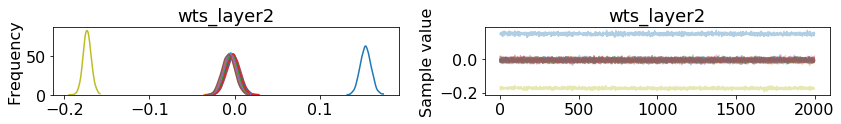

In [108]:
bnn_l1_nb.evaluate_fit(['wts_layer2']);

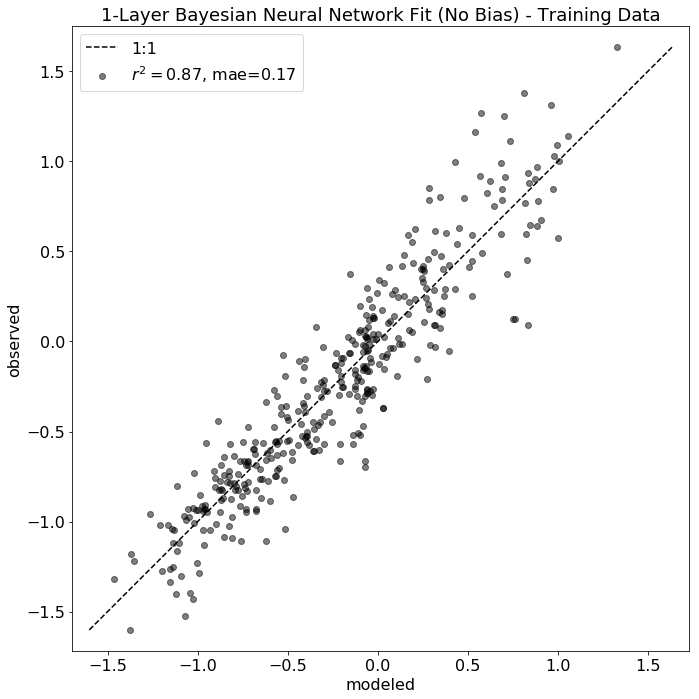

In [110]:
ppc_train_l1_nb = bnn_l1_nb.predict(X_shared, likelihood_name='likelihood')

bnn_l1_nb.plot_model_fits(y_train, ppc_train_l1_nb, loss_metric='mae',
                       title='1-Layer Bayesian Neural Network Fit (No Bias) - Training Data');

100%|██████████| 2000/2000 [00:01<00:00, 1283.74it/s]


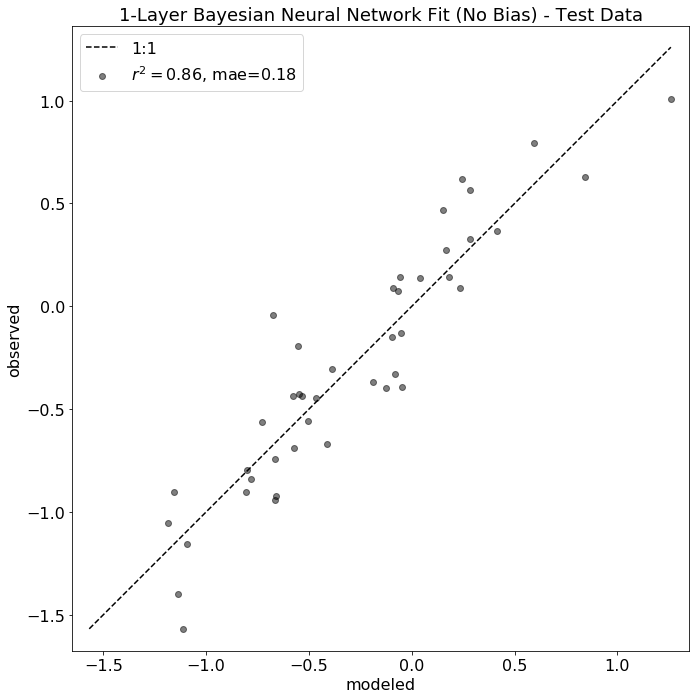

In [111]:
X_shared.set_value(X_s_test)

ppc_test_l1_nb = bnn_l1_nb.predict(X_shared, likelihood_name='likelihood')
bnn_l1_nb.plot_model_fits(y_test, ppc_test_l1_nb, loss_metric='mae',
                       title='1-Layer Bayesian Neural Network Fit (No Bias) - Test Data');

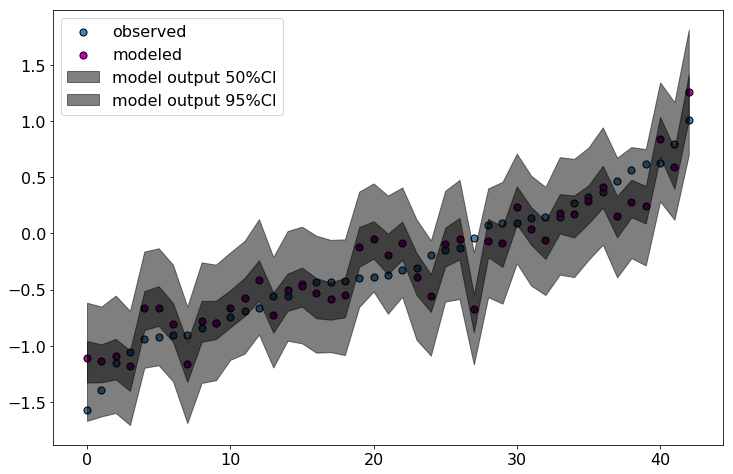

In [266]:
iy  = np.argsort(y_test)
ix = np.arange(iy.size)
lik_mean =ppc_test_l1_nb.mean(axis=0)
lik_hpd = pm.hpd(ppc_test_l1_nb)
lik_hpd_05 = pm.hpd(ppc_test_l1_nb, alpha=0.5)

f_fit2, ax = pl.subplots(figsize=(12, 8))
ax.scatter(ix, y_test.values[iy], label='observed', edgecolor='k', s=50,
           color='steelblue');
ax.scatter(ix, lik_mean[iy], label='modeled', edgecolor='k', s=50, color='m')

ax.fill_between(ix, y1=lik_hpd_05[iy, 0], y2=lik_hpd_05[iy, 1], alpha=0.5, color='k',
               label='model output 50%CI');
ax.fill_between(ix, y1=lik_hpd[iy, 0], y2=lik_hpd[iy, 1], alpha=0.5, color='k',
               label='model output 95%CI');
ax.legend(loc='upper left');
f_fit2.savefig('./figJar/bayesNet/bNN_L1_nobias.png', dpi=300, format='png')

### Fitting PCs only

In [70]:
X_s_train.head()

,sin_doy,cos_doy,sin_minofday,cos_minofday,x,y,z,log10_etopo2_s,oisst_s,solz_s,PC1_s,PC2_s,PC3_s,PC4_s,PC5_s,PC6_s
38,0.849817,0.527078,-0.983255,-0.182236,0.219567,-0.887413,0.405325,0.526432,0.511773,-0.027335,1.620220,-0.166773,0.969022,-0.518833,-1.979496,-1.809947
122,0.867456,0.497513,-0.866025,0.500000,0.104889,-0.881986,0.459456,-0.497966,0.172368,0.150342,1.335096,0.764691,-0.454115,-1.348854,-0.332997,0.601624
473,-0.615285,-0.788305,-0.991445,-0.130526,0.266145,-0.672171,0.690908,0.026485,-0.297645,-0.164009,0.053337,0.145197,0.617839,0.883799,0.018815,0.155470
157,-0.094537,-0.995521,-0.625923,-0.779884,0.110022,-0.891033,0.440403,-0.469499,0.811195,-1.252847,1.288289,0.019041,-0.086651,-0.665561,1.349379,1.208049
300,0.849817,0.527078,-0.969231,0.246153,-0.412636,-0.716726,0.562170,0.394419,-0.506442,0.446469,-0.222305,0.604505,0.335734,0.710931,0.317807,-0.896179


In [71]:
X_s_train_pc = X_s_train.filter(regex='PC', axis=1)
X_s_test_pc = X_s_test.filter(regex='PC', axis=1)

In [72]:
X_s_train_pc.shape

(380, 6)

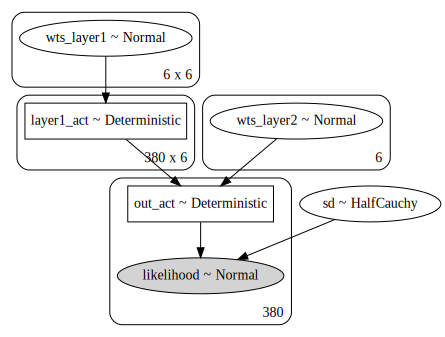

In [173]:
X_pc_shared = shared(X_s_train_pc.values)
bnn_l1_nb_pc = PyMCModel(bayes_nn_model_l1_no_bias, X_pc_shared, y_train, n_hidden=6)
bnn_l1_nb_pc.show_model()

In [174]:
prior_pc_l1nbpc = pm.sample_prior_predictive(model=bnn_l1_nb_pc.model)

In [175]:
bnn_l1_nb_pc.fit_ADVI(n_iter=500000)

Average Loss = 73.592: 100%|██████████| 500000/500000 [03:58<00:00, 2092.92it/s]
Finished [100%]: Average Loss = 73.587


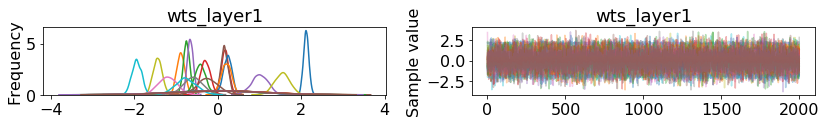

In [176]:
bnn_l1_nb_pc.evaluate_fit(['wts_layer1']);

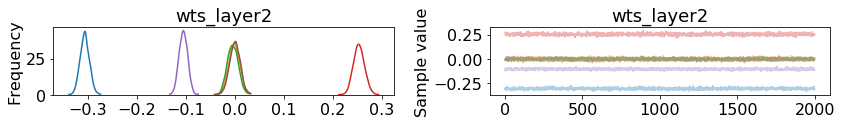

In [177]:
bnn_l1_nb_pc.evaluate_fit(['wts_layer2']);

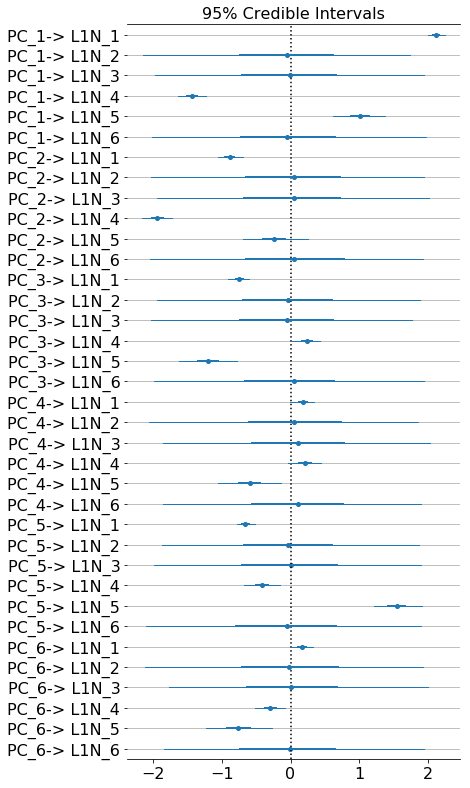

In [178]:
feat_labels = ['PC_%d-> L1N_%d' %(xi, ni) for xi in range(1, 7) for ni in range(1,7)]
bnn_l1_nb_pc.show_forest(['wts_layer1'], feat_labels=feat_labels);
f = pl.gcf()
f.set_figheight(12)

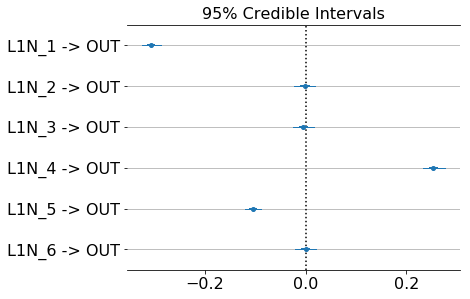

In [179]:
fl_2 = ['L1N_%d -> OUT' %ni for ni in range(1, 7)]
bnn_l1_nb_pc.show_forest(['wts_layer2'], feat_labels=fl_2);

100%|██████████| 2000/2000 [00:01<00:00, 1547.61it/s]


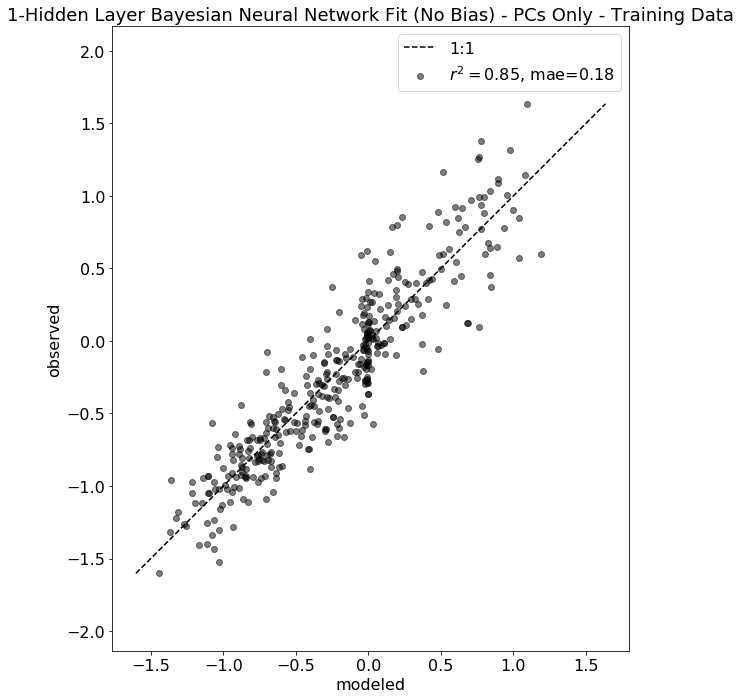

In [180]:
ppc_train_l1_nb_pc = bnn_l1_nb_pc.predict(X_pc_shared, likelihood_name='likelihood')

bnn_l1_nb_pc.plot_model_fits(y_train, ppc_train_l1_nb_pc, loss_metric='mae',
                       title='1-Hidden Layer Bayesian Neural Network Fit (No Bias) - PCs Only - Training Data');

100%|██████████| 2000/2000 [00:01<00:00, 1287.12it/s]


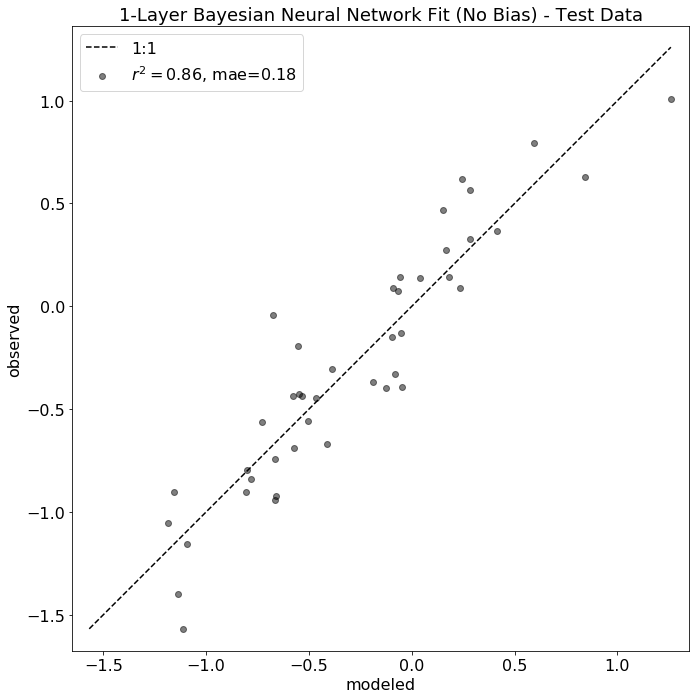

In [181]:
X_pc_shared.set_value(X_s_test_pc)

ppc_test_l1_nb_pc = bnn_l1_nb_pc.predict(X_pc_shared, likelihood_name='likelihood')
bnn_l1_nb_pc.plot_model_fits(y_test, ppc_test_l1_nb, loss_metric='mae',
                       title='1-Layer Bayesian Neural Network Fit (No Bias) - Test Data');

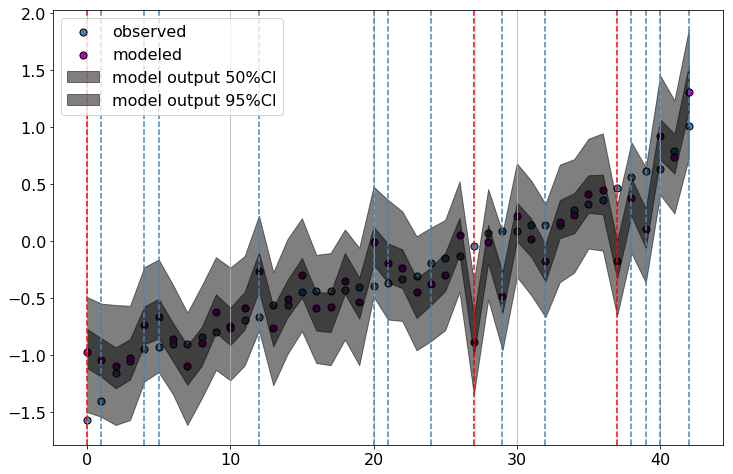

In [217]:
iy  = np.argsort(y_test.values)
ix = np.arange(iy.size)
lik_mean =ppc_test_l1_nb_pc.mean(axis=0)
lik_hpd = pm.hpd(ppc_test_l1_nb_pc)
lik_hpd_05 = pm.hpd(ppc_test_l1_nb_pc, alpha=0.5)

f_fit2, ax = pl.subplots(figsize=(12, 8))
ax.scatter(ix, y_test.values[iy], label='observed', edgecolor='k', s=50,
           color='steelblue');
ax.scatter(ix, lik_mean[iy], label='modeled', edgecolor='k', s=50, color='m')

ax.fill_between(ix, y1=lik_hpd_05[iy, 0], y2=lik_hpd_05[iy, 1], alpha=0.5, color='k',
               label='model output 50%CI');
ax.fill_between(ix, y1=lik_hpd[iy, 0], y2=lik_hpd[iy, 1], alpha=0.5, color='k',
               label='model output 95%CI');
ax.legend(loc='upper left');
f_fit2.savefig('./figJar/bayesNet/bNN_L1_nobias_pc.png', dpi=300, format='png')
for i in [0, 27, 37]:
    ax.axvline(i, color='r', linestyle='--')
ax.grid(axis='x')
for i in [1, 4, 5, 12, 20, 21, 24, 29, 32, 38, 39, 40, 42]:
    ax.axvline(i, color='steelblue', linestyle='--')

In [218]:
iyweird = [iy[i] for i in [0, 27, 37]]
iyweird95 = [iy[i] for i in [1, 4, 5, 12, 20, 21, 24, 29, 32, 38, 39, 40, 42]]

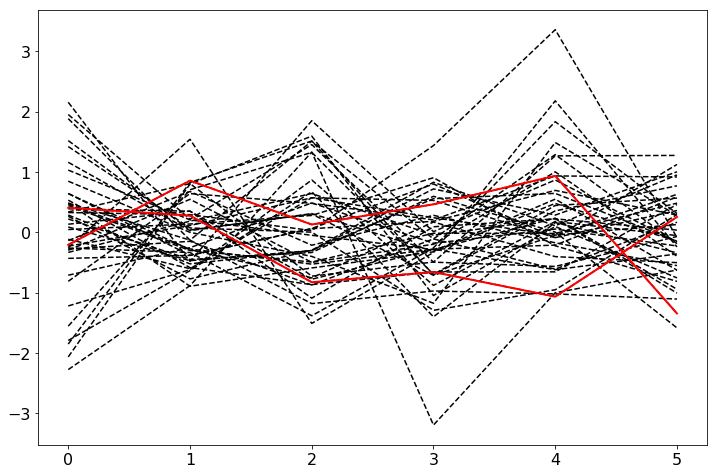

In [241]:
pl.figure(figsize=(12, 8))
pl.plot(np.arange(6), X_s_test_pc.values[iy].T, 'k--');
pl.plot(np.arange(6), X_s_test_pc.values[[27, 37]].T, 'r' ,linewidth=2)

#pl.plot(np.arange(6), X_s_test_pc.values[27].T, 'r' ,linewidth=2)
#pl.plot(np.arange(6), X_s_test_pc.values[iyweird95].T, color='steelblue' ,linewidth=2);

In [184]:
y_test.shape

(43,)

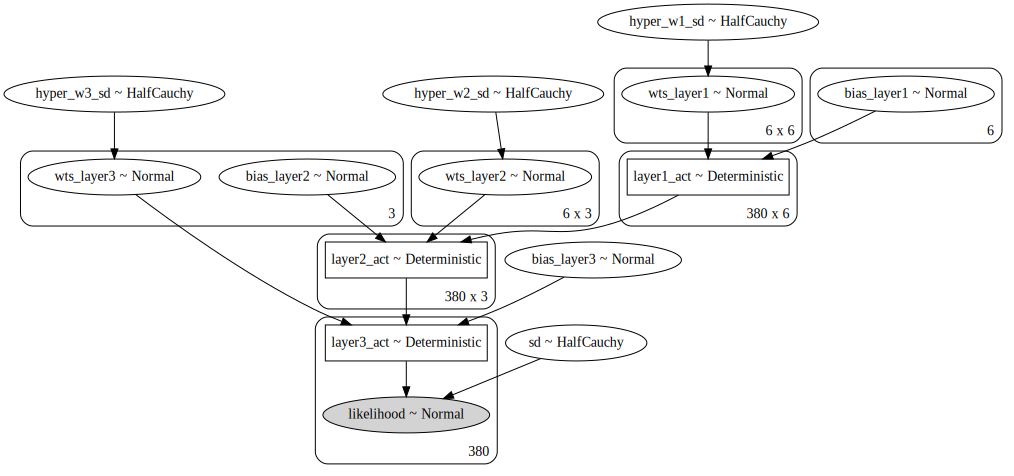

In [156]:
X_pc_shared = shared(X_s_train_pc.values)
bnn_l2h_pc = PyMCModel(bayes_nn_model2_l2_h, X_pc_shared, y_train, model_name='bnnl2',
                         n_hidden1=6, n_hidden2=3)
bnn_l2h_pc.show_model()

In [163]:
bnn_l2h_pc.fit_ADVI(n_iter=500000)

Average Loss = 92.95: 100%|██████████| 500000/500000 [05:12<00:00, 1599.71it/s] 
Finished [100%]: Average Loss = 92.93


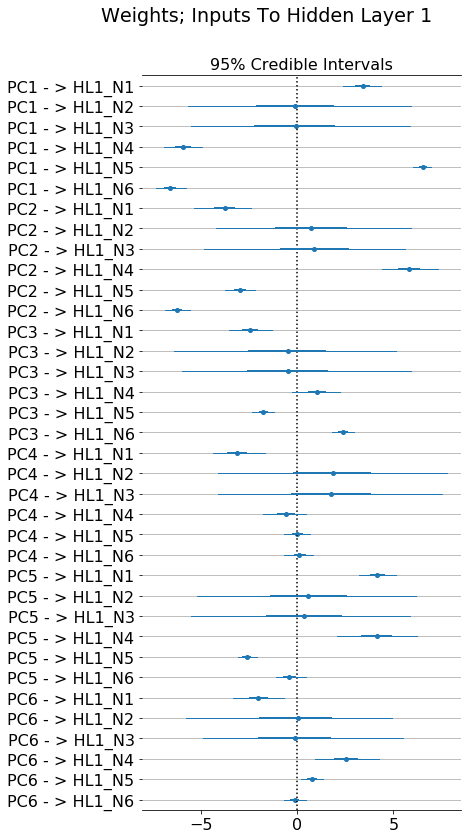

In [164]:
labels = ['PC%d - > HL1_N%d' %(l1n, l2n) for l1n in range(1, 7) for l2n in range(1, 7)]
bnn_l2h_pc.show_forest(['wts_layer1'], feat_labels=labels);
f = pl.gcf()
f.set_figheight(12)
f.suptitle('Weights; Inputs To Hidden Layer 1');

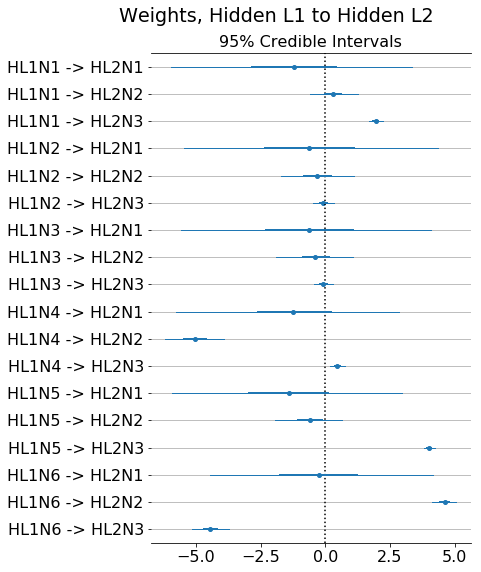

In [170]:
labels = ['HL1N%d -> HL2N%d' %(hl1n, hl2n) for hl1n in range(1, 7) for hl2n in range(1, 4)]

bnn_l2h_pc.show_forest(['wts_layer2'], feat_labels=labels);
f = pl.gcf()
f.set_figheight(8)
f.suptitle('Weights, Hidden L1 to Hidden L2');

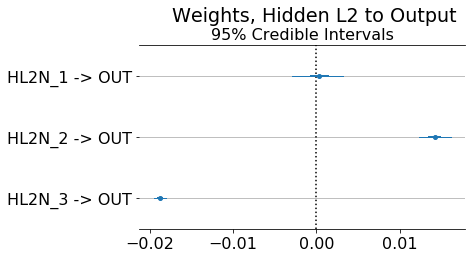

In [167]:
labels = ['HL2N_%d -> OUT' %ni for ni in range(1, 4)]
bnn_l2h_pc.show_forest(['wts_layer3'], feat_labels=labels);
f = pl.gcf()
#ax = pl.gca()
#ax.set_xlim(ax.get_xlim()[0]*2, 0.005)
f.set_figheight(3)
f.suptitle('Weights, Hidden L2 to Output', x=0.6, y=1.08);

100%|██████████| 2000/2000 [00:01<00:00, 1219.41it/s]


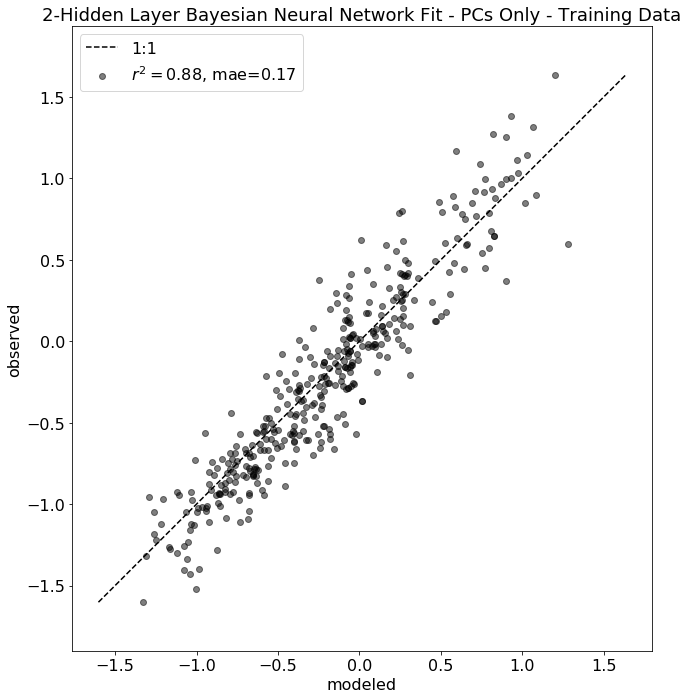

In [168]:
ppc_train_l2h = bnn_l2h_pc.predict(X_pc_shared, likelihood_name='likelihood')

bnn_l2h_pc.plot_model_fits(y_train, ppc_train_l2h, loss_metric='mae',
                       title='2-Hidden Layer Bayesian Neural Network Fit - PCs Only - Training Data'); 

100%|██████████| 2000/2000 [00:02<00:00, 951.32it/s]


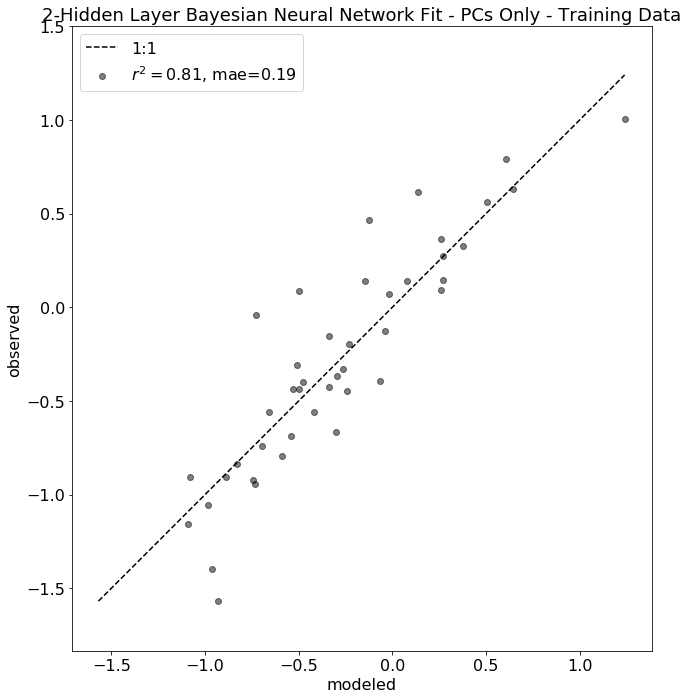

In [169]:
X_pc_shared.set_value(X_s_test_pc)
ppc_test_l2h = bnn_l2h_pc.predict(X_pc_shared, likelihood_name='likelihood')

bnn_l2h_pc.plot_model_fits(y_test, ppc_test_l2h, loss_metric='mae',
                       title='2-Hidden Layer Bayesian Neural Network Fit - PCs Only - Training Data'); 

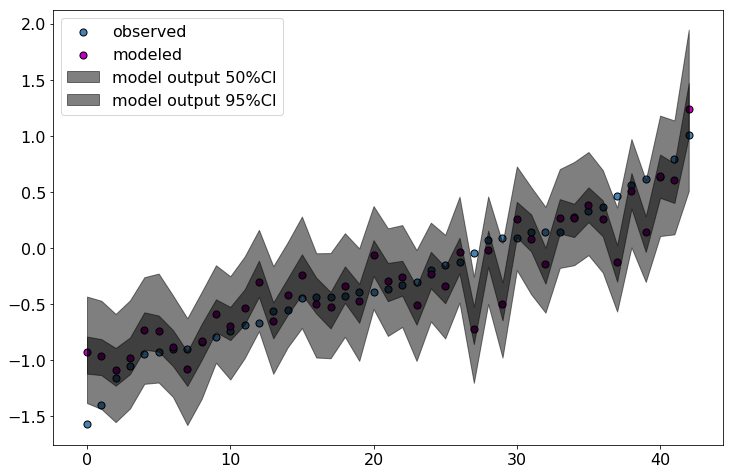

In [172]:
iy  = np.argsort(y_test)
ix = np.arange(iy.size)
lik_mean =ppc_test_l2h.mean(axis=0)
lik_hpd = pm.hpd(ppc_test_l2h)
lik_hpd_05 = pm.hpd(ppc_test_l2h, alpha=0.5)

f_fit2, ax = pl.subplots(figsize=(12, 8))
ax.scatter(ix, y_test.values[iy], label='observed', edgecolor='k', s=50,
           color='steelblue');
ax.scatter(ix, lik_mean[iy], label='modeled', edgecolor='k', s=50, color='m')

ax.fill_between(ix, y1=lik_hpd_05[iy, 0], y2=lik_hpd_05[iy, 1], alpha=0.5, color='k',
               label='model output 50%CI');
ax.fill_between(ix, y1=lik_hpd[iy, 0], y2=lik_hpd[iy, 1], alpha=0.5, color='k',
               label='model output 95%CI');
ax.legend(loc='upper left');
f_fit2.savefig('./figJar/bayesNet/bNN_L2.png', dpi=300, format='png')

In [245]:
X_s_train_pc_sst = X_s_train.loc[:, 'oisst_s':].drop('solz_s', axis=1)
X_s_test_pc_sst = X_s_test.loc[:, 'oisst_s':].drop('solz_s', axis=1)

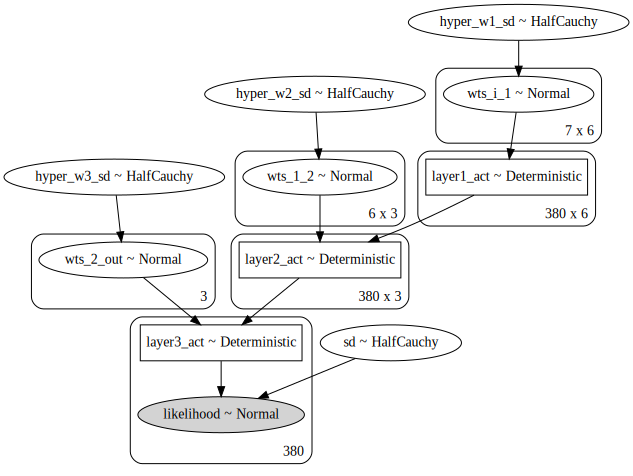

In [258]:
X_pc_sst_shared = shared(X_s_train_pc_sst.values)
bnn_l2h_pc_sst = PyMCModel(bayes_nn_model2_l2_h, X_pc_sst_shared, y_train, model_name='bnnl2',
                         n_hidden1=6, n_hidden2=3, include_bias=False)
bnn_l2h_pc_sst.show_model()

In [259]:
bnn_l2h_pc_sst.fit_ADVI(n_iter=500000)

Average Loss = 74.487: 100%|██████████| 500000/500000 [05:05<00:00, 1638.17it/s]
Finished [100%]: Average Loss = 74.5


100%|██████████| 2000/2000 [00:01<00:00, 1307.58it/s]


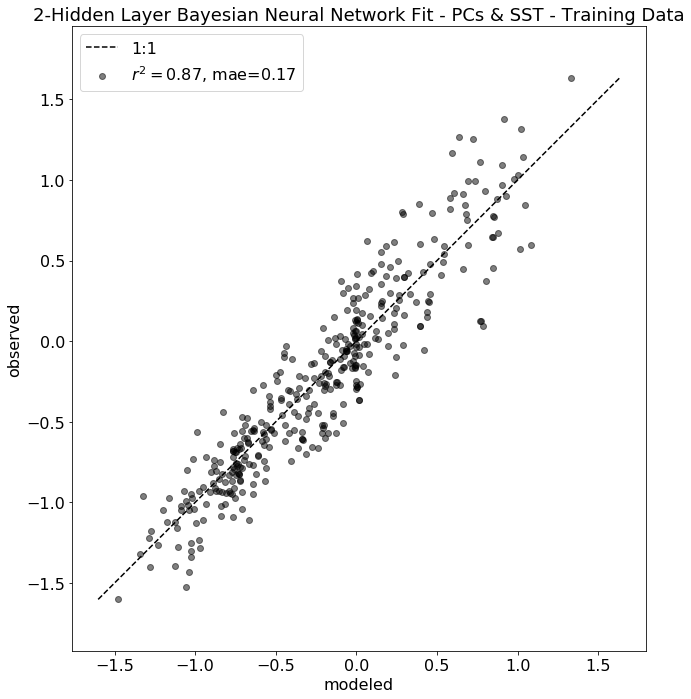

In [260]:
ppc_train_l2h_pc_sst = bnn_l2h_pc_sst.predict(X_pc_sst_shared, likelihood_name='likelihood')
bnn_l2h_pc_sst.plot_model_fits(y_train, ppc_train_l2h_pc_sst, loss_metric='mae',
                       title='2-Hidden Layer Bayesian Neural Network Fit - PCs & SST - Training Data'); 

100%|██████████| 2000/2000 [00:01<00:00, 1065.55it/s]


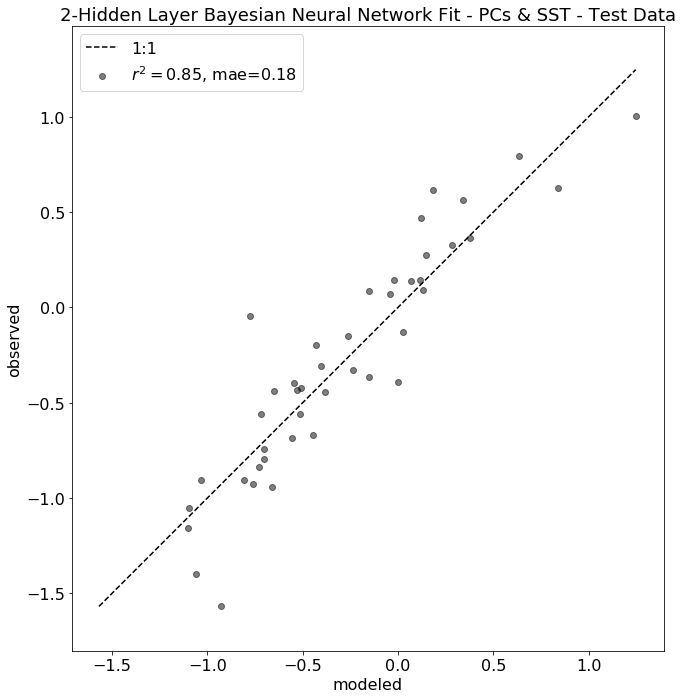

In [261]:
X_pc_sst_shared.set_value(X_s_test_pc_sst)
ppc_test_l2h_pc_sst = bnn_l2h_pc_sst.predict(X_pc_sst_shared, likelihood_name='likelihood')

bnn_l2h_pc_sst.plot_model_fits(y_test, ppc_test_l2h_pc_sst, loss_metric='mae',
                       title='2-Hidden Layer Bayesian Neural Network Fit - PCs & SST - Test Data'); 

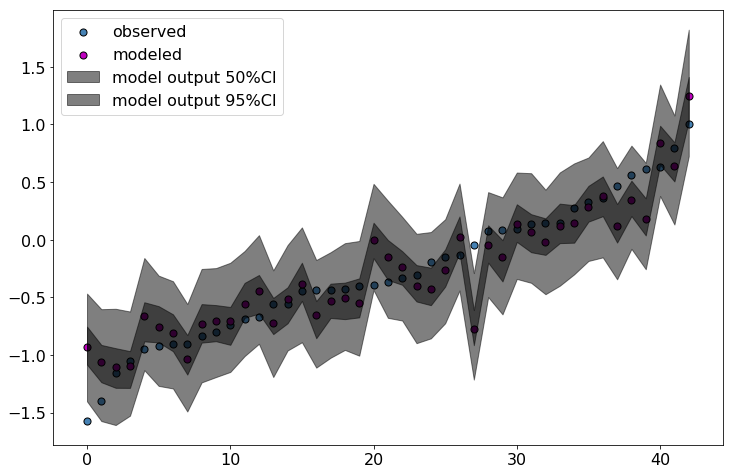

In [262]:
iy  = np.argsort(y_test)
ix = np.arange(iy.size)
lik_mean =ppc_test_l2h_pc_sst.mean(axis=0)
lik_hpd = pm.hpd(ppc_test_l2h_pc_sst)
lik_hpd_05 = pm.hpd(ppc_test_l2h_pc_sst, alpha=0.5)

f_fit2, ax = pl.subplots(figsize=(12, 8))
ax.scatter(ix, y_test.values[iy], label='observed', edgecolor='k', s=50,
           color='steelblue');
ax.scatter(ix, lik_mean[iy], label='modeled', edgecolor='k', s=50, color='m')

ax.fill_between(ix, y1=lik_hpd_05[iy, 0], y2=lik_hpd_05[iy, 1], alpha=0.5, color='k',
               label='model output 50%CI');
ax.fill_between(ix, y1=lik_hpd[iy, 0], y2=lik_hpd[iy, 1], alpha=0.5, color='k',
               label='model output 95%CI');
ax.legend(loc='upper left');
f_fit2.savefig('./figJar/bayesNet/bNN_L2_pc_sst.png', dpi=300, format='png')

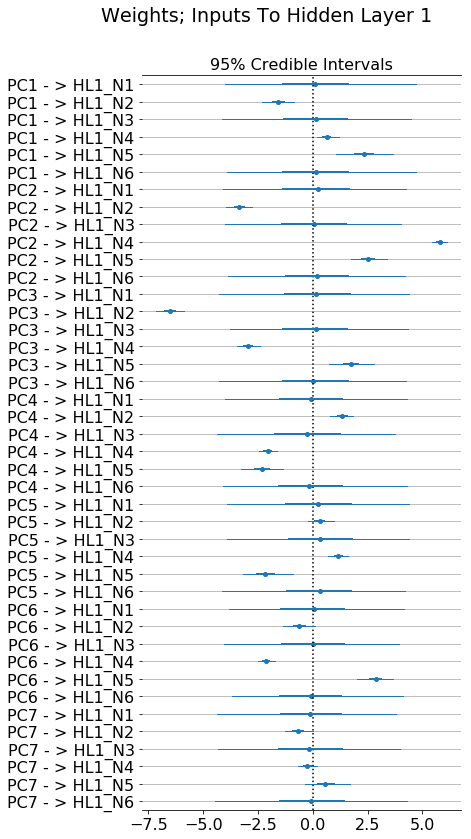

In [263]:
labels = ['PC%d - > HL1_N%d' %(l1n, l2n) for l1n in range(1, 8) for l2n in range(1, 7)]
bnn_l2h_pc_sst.show_forest(['wts_i_1'], feat_labels=labels);
f = pl.gcf()
f.set_figheight(12)
f.suptitle('Weights; Inputs To Hidden Layer 1');

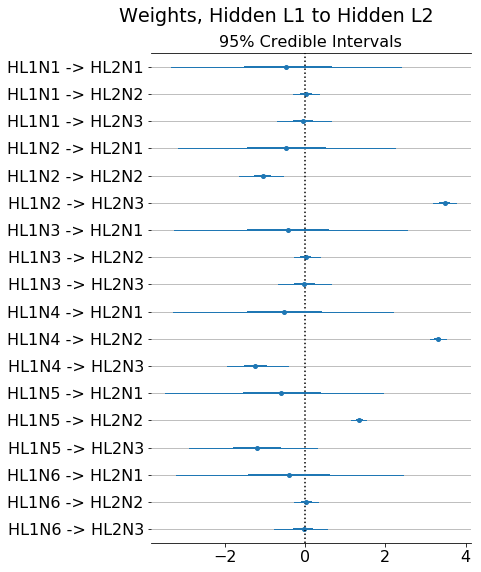

In [264]:
labels = ['HL1N%d -> HL2N%d' %(hl1n, hl2n) for hl1n in range(1, 7) for hl2n in range(1, 4)]

bnn_l2h_pc_sst.show_forest(['wts_1_2'], feat_labels=labels);
f = pl.gcf()
f.set_figheight(8)
f.suptitle('Weights, Hidden L1 to Hidden L2');

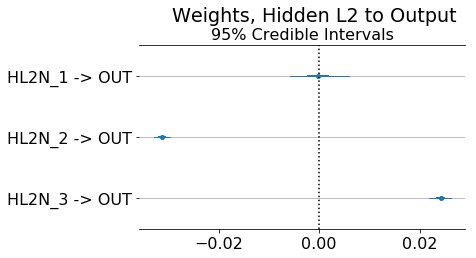

In [265]:
labels = ['HL2N_%d -> OUT' %ni for ni in range(1, 4)]
bnn_l2h_pc_sst.show_forest(['wts_2_out'], feat_labels=labels);
f = pl.gcf()
#ax = pl.gca()
#ax.set_xlim(ax.get_xlim()[0]*2, 0.005)
f.set_figheight(3)
f.suptitle('Weights, Hidden L2 to Output', x=0.6, y=1.08);